# **Step 1 :- Data Preprocessing**

## 1.1 Importing all the necessary packages and classes

In [1]:
%matplotlib inline
import smogn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import axes3d
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression

## 1.2 Importing Genotypic data (features) and Phenotypic data (labels)

In [2]:
df_genotypes = pd.read_csv('genotypes.csv').sort_values(by=["sample_ids"], ascending=True)

df_phenotypes = pd.read_csv('phenotype_values.csv').sort_values(by=["sample_ids"], ascending=True)

# -Lakruvini perera- -Dinuka Jayalath-

**Genotypes data**

In [3]:
df_genotypes.head(5)

,sample_ids,1_10904,1_61822,1_156628,1_191062,1_208851,1_280584,1_284187,1_395787,1_416711,...,5_26715506,5_26743638,5_26754590,5_26777015,5_26815991,5_26830746,5_26915718,5_26922046,5_26924854,5_26957850
267,1,G,G,?,C,?,C,?,A,?,...,T,?,C,A,A,A,T,A,T,A
64,2,?,G,G,C,G,T,C,?,G,...,T,T,C,G,A,A,T,A,?,C
45,4,G,G,A,?,G,T,C,A,A,...,T,T,C,A,A,G,T,?,T,A
657,5,G,?,A,C,G,C,T,A,G,...,A,T,T,A,A,G,A,A,T,A
1261,6,G,G,A,C,?,C,C,A,G,...,A,T,?,A,A,?,T,A,T,A


## 1.3 Imputation of *'?'* using most occurring neucleotide (mode) of each column (SNPs) 

**Imputation:**
Data set has some missing data which are denoted with question marks(?). They are replaced with the mode of each column.

**Explanation:** 
Since a column represents one SNP, for each SNP there can be only two options (two types of nucleic bases) and from these two, one appears more frequently than the other (major allele:more frequent base of one SNP, minor allele:less frequent base of that SNP). So to have a fair result the unknown results were replaced with the most frequent option (major allele). 

In [4]:
# defining a funtion for the imputation step

def question_mark_replacement(dataframe_to_replace):
    for column in dataframe_to_replace:
        dataframe_to_replace[column] = dataframe_to_replace[column].replace('?', (dataframe_to_replace[column].mode()[0]))
    
    return dataframe_to_replace


df_genotypes = question_mark_replacement(df_genotypes)
df_genotypes.head(5)

# -Lakruvini perera-

,sample_ids,1_10904,1_61822,1_156628,1_191062,1_208851,1_280584,1_284187,1_395787,1_416711,...,5_26715506,5_26743638,5_26754590,5_26777015,5_26815991,5_26830746,5_26915718,5_26922046,5_26924854,5_26957850
267,1,G,G,G,C,G,C,C,A,G,...,T,T,C,A,A,A,T,A,T,A
64,2,G,G,G,C,G,T,C,A,G,...,T,T,C,G,A,A,T,A,T,C
45,4,G,G,A,C,G,T,C,A,A,...,T,T,C,A,A,G,T,A,T,A
657,5,G,G,A,C,G,C,T,A,G,...,A,T,T,A,A,G,A,A,T,A
1261,6,G,G,A,C,G,C,C,A,G,...,A,T,C,A,A,G,T,A,T,A


*All the '?' have been replaced without affecting the order of the data*

## 1.4 Checking whether we have all the sample IDs and their similarity for Input and Output

In [5]:
sample_id_genotypes = df_genotypes['sample_ids'].to_numpy()    
sample_id_phenotypes = df_phenotypes['sample_ids'].to_numpy()

truth_array = sample_id_genotypes == sample_id_phenotypes  

Truth_result = np.unique(truth_array,return_counts=True)

print('Is sample IDs are matching with Genotypes and Phenotypes -->',Truth_result[0])
print('Total number of sample IDs matching -->',Truth_result[1])

# -Dinuka Jayalath-

Is sample IDs are matching with Genotypes and Phenotypes --> [ True]
Total number of sample IDs matching --> [1826]


**This ensures that we have all the sample IDs in Both Genotype and phenotype data and they are corresponding to each other**

## 1.5 Additive Encoding for Genotype Data

Encoding is converting general data into a machine readable format. There are few methods of doing this. The method used in this project is called 'additive encoding'. In the data set, for each SNP (feature) there are two options as the major and minor allele. In additive encoding method the major allele is encoded with '0' and the minor allele with '2'

In [6]:
# defining a function to encode the given dataframe

def aditive_encoding(genotype_dataframe):
    
    df_genotypes_encoding = genotype_dataframe.drop('sample_ids',axis = 1)    # Dropping the 'Sample ID' for encoding

    Input_all = np.zeros(df_genotypes_encoding.shape,dtype = int)       # Creating an np array with the same shape as of the genotype data
    column_number = 0
    for col in df_genotypes_encoding.columns:
        whole_column = df_genotypes_encoding[col]    # Reading through each column
        mode = whole_column.mode()[0]                # Determining the major allele and minor allele by finding the 'mode'
        for i, element in enumerate(whole_column):
            if element == mode:
                Input_all[i,column_number] = 0       # Replacing with 0 if it's the Major alelle
            else :
                Input_all[i,column_number] = 2       # Replacing with 2 if it's the Minor alelle
        column_number = column_number + 1            # to read along the columns
    return Input_all                                 # This will return the encoded input array


Input_all = aditive_encoding(df_genotypes)
print('Shape of the Input_all Array -->', Input_all.shape)

# -Lakruvini perera- -Dinuka Jayalath-

Shape of the Input_all Array --> (1826, 5000)


**To ensure and confirm that the array has been encoded correctly, the first 10 rows and 5 columns in both the array and the dataframe are printed below and cross checked**

In [7]:
df_new = df_genotypes.iloc[0:10,1:5]   # slicing the whole dataframe

print('Input array 1st 10 rows and 5 columns')
print(Input_all[0:10,0:5])
print()
print('Genotype dataframe 1st 10 rows and 5 columns')
df_new

Input array 1st 10 rows and 5 columns
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]
 [0 0 2 0 0]
 [0 0 2 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 0]
 [2 0 2 0 0]
 [2 0 0 0 0]]

Genotype dataframe 1st 10 rows and 5 columns


,1_10904,1_61822,1_156628,1_191062
267,G,G,G,C
64,G,G,G,C
45,G,G,A,C
657,G,G,A,C
1261,G,G,A,C
1480,G,G,G,C
1516,G,G,G,C
1376,G,G,A,C
1035,A,G,A,C
445,A,G,G,C


This ensures that **it has been replaced correctly with major and minor alleles** in the order of sample IDs

## 1.6 Converting Phenotype data

In [8]:
df_phenotypes = pd.read_csv('phenotype_values.csv',index_col='sample_ids')     #setting the index in to sample IDs so its in the same order as genotypes
df_phenotypes = df_phenotypes.sort_values(by=["sample_ids"], ascending=True)
df_phenotypes.head(5)

,phenotype_values
sample_ids,
1,54.95
2,56.98
4,57.22
5,56.72
6,58.59


**Phenotypic data are also sorted in the ascending order relative to sample_ids to match with the of the genotypic data**

## 1.7 Shapes of Input and output 

In [9]:
Output_all = df_phenotypes.to_numpy().reshape(1826,)  # converting it to numpy with whole output with all the trials

print('Shape of the Input_all Array:\t'+ str(Input_all.shape))
print('Shape of the Output_all Array:\t'+ str(Output_all.shape))

Shape of the Input_all Array:	(1826, 5000)
Shape of the Output_all Array:	(1826,)


# **Step 2 :- Dimensionality Reduction**

## 2.1 Dimensionality Reduction with Principal Components

*Principal Component Analysis (PCA) is a method used for reducing dimensionality of data sets with large numbers of variables, while trying to preserve the maximum possible amount of information. Although this affects the accuracy, it comes with some other benefits like simplicity, easy exploration and visualization and faster machine learning algorithms.*

*Here the existing feature variables are represented using a new set of variables in a way that there is no correlation between two variables of the new set. The most correlated features from the previous set are squeezed into the first principal component and, then out of the rest again this is done for the second Principal Component and so on.* 

*Visualizing our data was a challenge due to the large number of features. Our main goal with PCA was to use it for a simpler and better visualization of our data set.*

**PC1 graph**
- This graph depicts the correlation between the first Principle Component(x axis) and the Phenotypic values(y axis). About 10.14% of the total variance is explained by the first PC. Here the data for both training and testing data are plotted and it can be seen that the distribution of data between testing and training is evenly done throughout the data set. 

**PC3 graph**
- This is a 3D graph with a color gradient bar. The 3 axes are used to depict the correlation between the first 3 Principal Components and the color gradient is used for the phenotypic values. With the first 3 components about 22% of the total data are represented.*


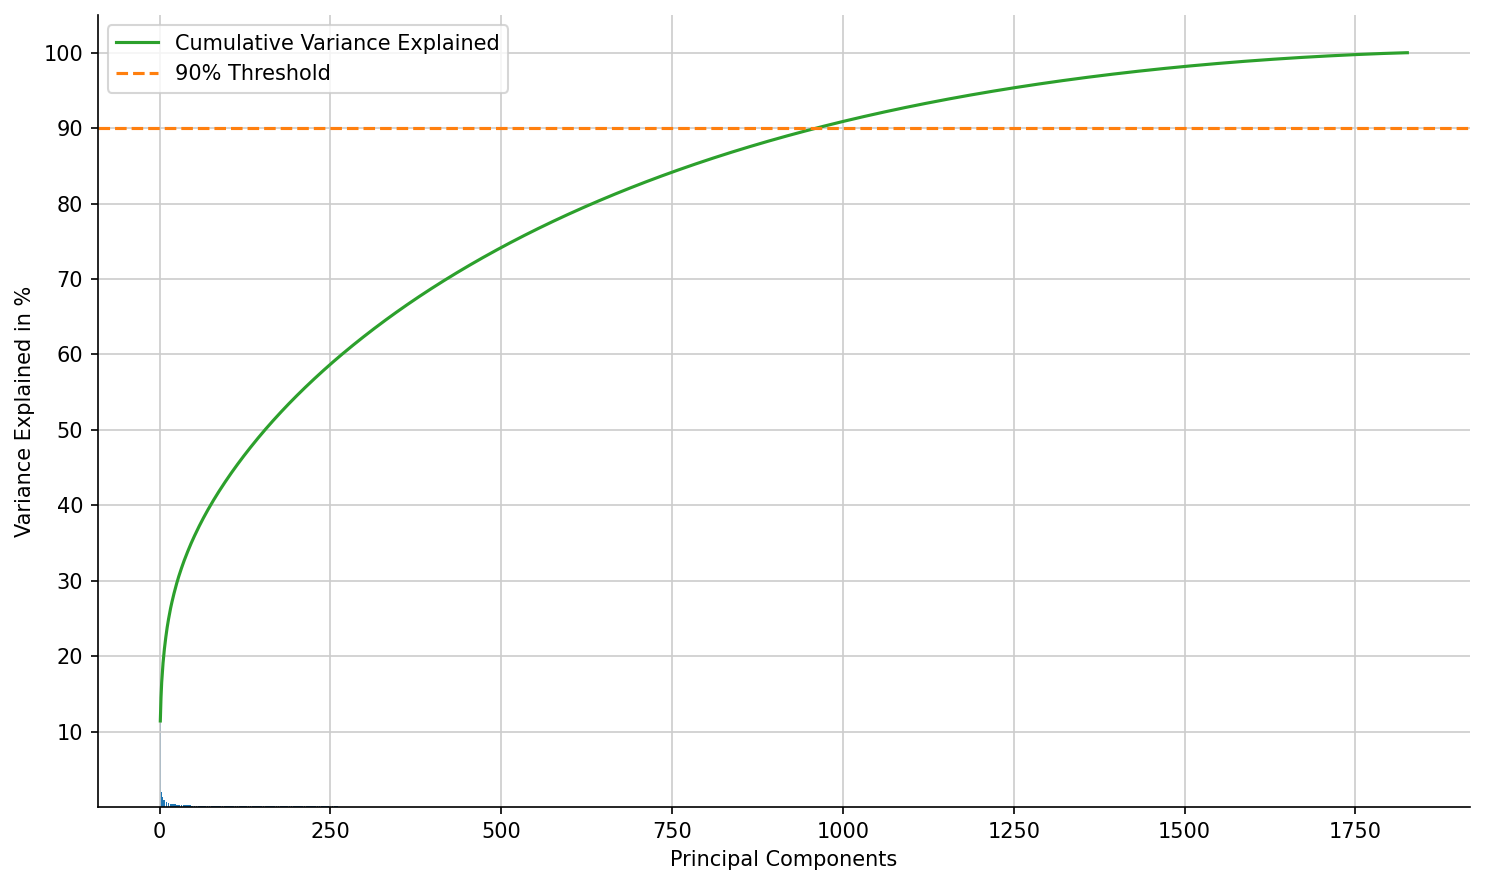

In [11]:
pca = PCA()                                    # This uses maximum number of Principal Components
scaler = StandardScaler()
scaled_Input_all = scaler.fit_transform(Input_all)

pca.fit(scaled_Input_all)
fig_PCA_main = plt.figure(dpi = 150,figsize=(10,6))
n= 1826
ax = plt.subplot(111)
ax.bar(np.arange(1,1+len(pca.explained_variance_[0:n])),pca.explained_variance_ratio_[0:n]*100)
ax.plot(np.arange(1,1+len(pca.explained_variance_[0:n])), np.cumsum(pca.explained_variance_ratio_[0:n])*100,color="tab:green", label="Cumulative Variance Explained")
ax.set_yticks([10,20,30,40,50,60,70,80,90,100])
plt.axhline(90,color="tab:orange",linestyle="dashed",label="90% Threshold")

ax.grid(color="#CCCCCC")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Principal Components")
ax.set_ylabel("Variance Explained in %")
plt.legend()
plt.tight_layout()

fig_PCA_main.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/PCA_analisis.pdf',bbox_inches ='tight', dpi = 400)

#-Lakruvini perera- 

# **Step 3 :- Data Visualization with Principle Components**

## 3.1 Using only the first PC with phenotypic data 

 The new shape of the Train data is: (1460, 1)
 The new shape of the Test data is : (366, 1)


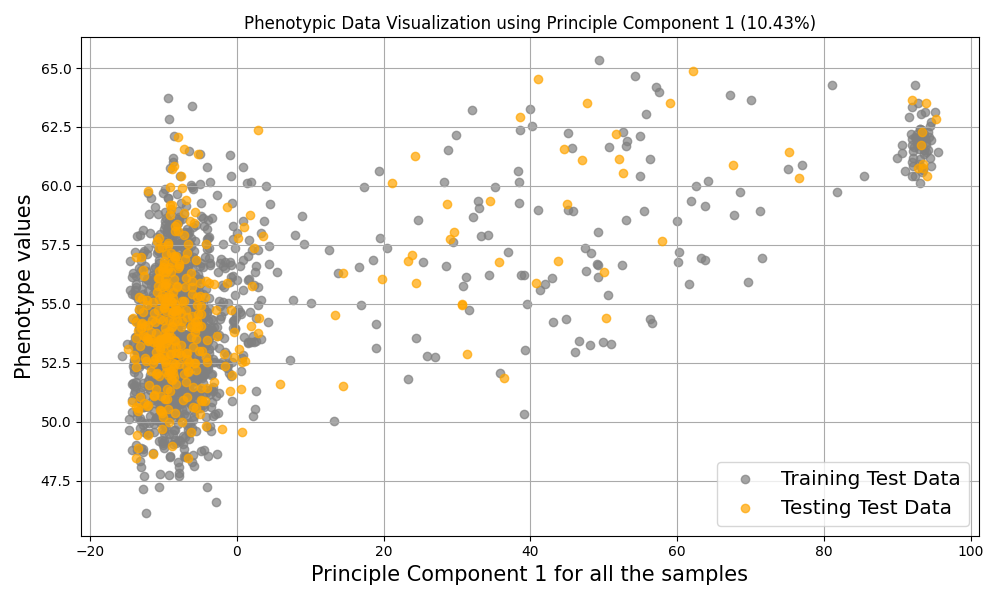

In [20]:
#Splitting data in to 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(Input_all,Output_all, test_size=0.2, random_state=42,shuffle = True)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

pca = PCA(n_components=1)
X_train_PCA1 = pca.fit_transform(scaled_X_train)
X_test_PCA1 = pca.transform(scaled_X_test)
print(' The new shape of the Train data is:', X_train_PCA1.shape)
print(' The new shape of the Test data is :', X_test_PCA1.shape)

PCA1_FIG = plt.figure(figsize=(10, 6),dpi = 100)
ax.set_facecolor('white')
plt.scatter(X_train_PCA1,y_train,zorder=1,alpha=0.7,label="Training Test Data",marker = "o", c='grey',edgecolor="grey")
plt.scatter(X_test_PCA1,y_test,zorder=2,alpha=0.7,label="Testing Test Data", marker = "o",c='orange')
plt.grid(color="#AAAAAA")
plt.title('Phenotypic Data Visualization using Principle Component 1 (10.43%)')
plt.xlabel("First Principle Component for all the samples", fontsize=15)
plt.ylabel("Phenotypic values",fontsize=15)
plt.legend(loc='lower right',fontsize='x-large')
plt.show()

PCA1_FIG.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/PC1_vs_phenotypes.pdf',bbox_inches ='tight', dpi = 300)

#-Dinuka Jayalath- -Lakruvini Perera - 

## 3.2 Using PC1, PC2 and PC3 with phenotypic data 

In [13]:
pca3 = PCA(n_components=3)

scaler = StandardScaler()
scaled_Input_all = scaler.fit_transform(Input_all)
Input_all_PCA3 = pca3.fit_transform(scaled_Input_all)
print(' The new shape of the Train data is:', Input_all_PCA3.shape)

 The new shape of the Train data is: (1826, 3)


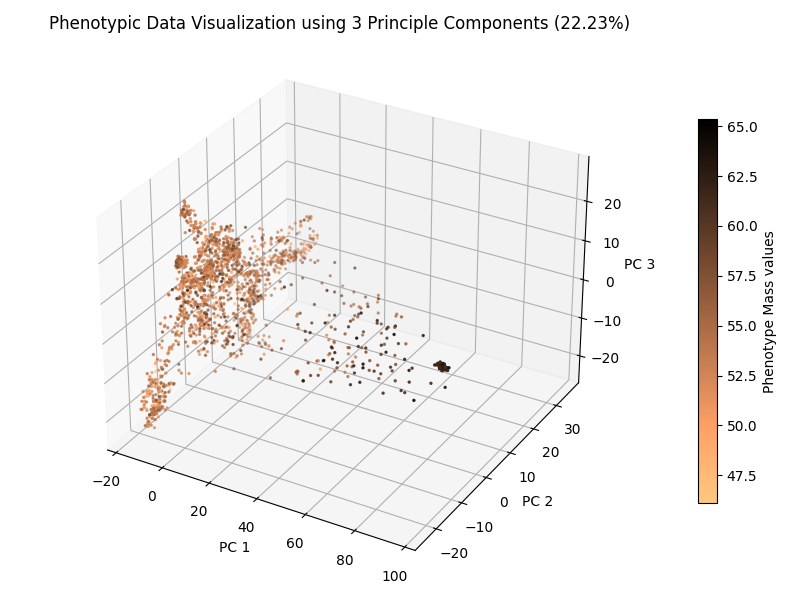

In [14]:
Input_all_PCA3_1 = Input_all_PCA3[:,0]
Input_all_PCA3_2 = Input_all_PCA3[:,1]
Input_all_PCA3_3 = Input_all_PCA3[:,2]

%matplotlib widget

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

PC3_3D_PLOT = plt.figure(dpi = 100)
ax = plt.axes(projection = '3d')
sc1 = ax.scatter3D(Input_all_PCA3_1,Input_all_PCA3_2,Input_all_PCA3_3,s=2,c=Output_all,cmap = 'copper_r')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.title('Phenotypic Data Visualization using 3 Principle Components (22.23%)')
plt.colorbar(sc1,label = 'Phenotypic Biomass values',location = 'right',shrink = 0.7,anchor = (0.5, 0.5))
plt.show()

PC3_3D_PLOT.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/PC3_3D_PLOT.pdf',bbox_inches ='tight', dpi = 400)

#-Dinuka Jayalath- -Lakruvini Perera - 

A better visualization was achieved using the first three PCs were plotted against each other using a 3D plot as shown above. 
Here the dimensionality has been reduced upto 3 and variance explained is 22.23%.

**However This 3D plot gave us the intuition, the dataset might be imbalanced with higher phenotype mass samples. (There are very less dark dots/samples)**

**This lead us to investigate the distribution of the output values in our dataset**

# **Step 4** :- Investigating the distribution of the dataset

## 4.1 Histogram of output data

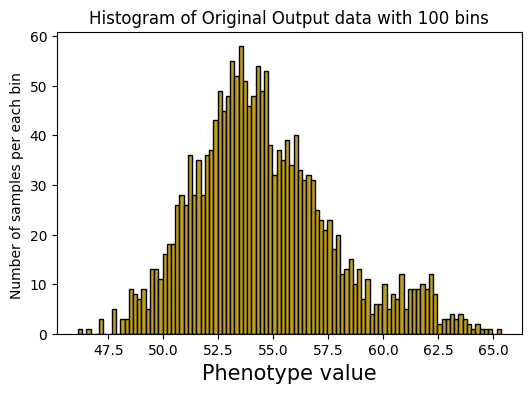

In [33]:
hist_fig_output_all = plt.figure(dpi=100)
ax1 = hist_fig_output_all.add_subplot(111)
plt.hist(Output_all,bins = 100,color = '#bc9c22',histtype='bar',ec='black')
ax1.set_xlabel('Phenotype value',fontsize = 15)
ax1.set_ylabel('Number of samples per each bin ',fontsize = 10)
plt.title('Histogram of Original Output data with 100 bins')
plt.show()

hist_fig_output_all.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/histogram_output_all.pdf',bbox_inches ='tight', dpi = 400)

#-Dinuka Jayalath-

### P-value of the distribution

In [25]:
P_value = (stats.shapiro(Output_all))[1]
P_value

4.709526347791061e-18

**Shapiro-Wilk test is a test of normality, it determines whether the given sample comes from the normal distribution or not.**
 - Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
 - Ha(Rejected): Sample is not from the normal distributions.
 
Since the p-value is 4.709526347791061e-18, which is way lower than the threshold (P=0.05); the distribution is not normal.

**Thus, using R2 or Corelation coefficient as mesurement scores would not be ideal.**

# **Step 5 :- Model Selection**

## 5.1 Explanation

From the raw data provided, it can be concluded that this is a continuous type data distribution and the categories have an order, thus classifier ML models cannot be applied, and regression ML models should be applied. Here we use different types of  scikit regression models to test and train the model predictions.

- Several kernels are applied for SVR model and some other complex regression models also has been tested.

- When training a SVR, two parameters must be considered: C and gamma. The parameter C is common to all SVM kernels, trade off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training sample correctly, but with a danger of overfitting. Gamma defines how much influence a single training sample has. The larger gamma is, the closer other samples must be to be affected.

- Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

## 5. 2 Testing different regression models and evaluation with cross validation

### Lasso Model

In [51]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.linspace(0.02,0.05,15)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = linear_model.Lasso(alpha=C,max_iter = -1) 
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = linear_model.Lasso(alpha=best_C,max_iter = -1) 
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/Lasso/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/Lasso/best_ex_variance_val.npy',best_ex_variance_val)

print("Average C Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average C Value: 0.04 (+- 0.01)
Best Explained variance (Val): 0.59 (+- 0.03)
Best Explained variance (Test): 0.53 (+- 0.12)
MSE (Val): 3.96 (+- 0.17)
MSE (Test): 4.33 (+- 0.29)


### SVR - 'Polynomial' kernel with 5 fold cross validation

In [23]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.arange(5,15)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = svm.SVR(kernel = 'poly',degree = 2,C = C,cache_size = 4000)
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = svm.SVR(kernel = 'poly',degree = 2,C = best_C,cache_size = 4000)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/SVR_poly/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/SVR_poly/best_ex_variance_val.npy',best_ex_variance_val)

print("Average C Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average C Value: 11.40 (+- 2.50)
Best Explained variance (Val): 0.55 (+- 0.08)
Best Explained variance (Test): 0.44 (+- 0.15)
MSE (Val): 4.68 (+- 0.49)
MSE (Test): 5.16 (+- 0.28)


### SVR - 'rbf' kernel with 5 fold cross validation

In [24]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.linspace(5,25,10)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = svm.SVR(kernel = 'rbf',C = C,cache_size = 4000,max_iter = -1)
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = svm.SVR(kernel = 'rbf',C = best_C,cache_size = 4000,max_iter = -1)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/SVR_RBF/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/SVR_RBF/best_ex_variance_val.npy',best_ex_variance_val)

print("Average C Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average C Value: 9.44 (+- 3.14)
Best Explained variance (Val): 0.54 (+- 0.05)
Best Explained variance (Test): 0.44 (+- 0.13)
MSE (Val): 4.40 (+- 0.33)
MSE (Test): 5.16 (+- 0.34)


### NuSVR - 'rbf' kernel with 5 fold cross validation

In [25]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.arange(5,15)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = svm.NuSVR(kernel = 'rbf',C = C,cache_size = 4000,max_iter = -1)
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = svm.NuSVR(kernel = 'rbf',C = best_C,cache_size = 4000,max_iter = -1)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/NU_SVR_RBF/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/NU_SVR_RBF/best_ex_variance_val.npy',best_ex_variance_val)

print("Average alpha Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average alpha Value: 12.40 (+- 1.36)
Best Explained variance (Val): 0.57 (+- 0.05)
Best Explained variance (Test): 0.45 (+- 0.12)
MSE (Val): 4.69 (+- 0.49)
MSE (Test): 5.13 (+- 0.34)


### kernel_ridge - with 5 fold cross validation

In [15]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.linspace(0.001,1,10)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = KernelRidge( kernel = 'poly',degree = 2,alpha = C)  # here its the alpha ***
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = KernelRidge( kernel = 'poly',degree = 2,alpha = best_C)  # here its the alpha ***
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/KernelRidge/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/KernelRidge/best_ex_variance_val.npy',best_ex_variance_val)

print("Average C Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average C Value: 0.02 (+- 0.04)
Best Explained variance (Val): 0.57 (+- 0.04)
Best Explained variance (Test): 0.50 (+- 0.11)
MSE (Val): 4.48 (+- 0.35)
MSE (Test): 4.66 (+- 0.36)


### BayesianRidge - with 5 fold corss validation for alpha between 0.001-0.1

In [26]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.linspace(0.001,1,10)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = BayesianRidge(n_iter = 5000,alpha_2 = C)
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = BayesianRidge(n_iter = 5000,alpha_2 = best_C)  # C is the Neighbors here
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/BayesianRidge/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/BayesianRidge/best_ex_variance_val.npy',best_ex_variance_val)

print("Average aplpha Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average aplpha Value: 0.80 (+- 0.40)
Best Explained variance (Val): 0.58 (+- 0.05)
Best Explained variance (Test): 0.50 (+- 0.11)
MSE (Val): 4.50 (+- 0.43)
MSE (Test): 4.69 (+- 0.38)


### TweedieRegressor - with 5 fold corss validation for alpha between 1-10

In [27]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.linspace(0.1,1,10)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = TweedieRegressor(max_iter = 500,power = 2,alpha = C)
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = TweedieRegressor(max_iter = 500,power = 2,alpha = best_C)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/TweedieRegressor/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/TweedieRegressor/best_ex_variance_val.npy',best_ex_variance_val)

print("Average aplpha Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average aplpha Value: 0.30 (+- 0.13)
Best Explained variance (Val): 0.59 (+- 0.06)
Best Explained variance (Test): 0.50 (+- 0.10)
MSE (Val): 4.23 (+- 0.31)
MSE (Test): 4.72 (+- 0.40)


### K Neighbors Regressor - with 5 fold cross validation for k between 1-10

In [28]:
kf = KFold(n_splits=5)

best_ex_variance_val = []
best_ex_variance_test = []
best_MSE_val = []
best_MSE_test = []
best_C_list = []

for train_index, test_index in kf.split(Input_all,Output_all):
    X_train = Input_all[train_index]
    X_test = Input_all[test_index]
    y_train = Output_all[train_index]
    y_test = Output_all[test_index]
    
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)
    Cs = np.arange(1,10)
    
    ex_variance_val_list = []
    MSE_val_list = []
    
    for C in Cs:
        model = KNeighborsRegressor(n_neighbors = C) 
        model.fit(X_subtrain, y_subtrain)
        y_pred_val = model.predict(X_val)
        ex_variance_val = explained_variance_score(y_val,y_pred_val)
        MSE_val = mean_squared_error(y_val,y_pred_val)
        ex_variance_val_list.append(ex_variance_val)
        MSE_val_list.append(MSE_val)
    
    best_C = Cs[np.argmax(ex_variance_val_list)]
    
    #testing the model with full testing data
    model = KNeighborsRegressor(n_neighbors = best_C) 
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    ex_variance_test = explained_variance_score(y_test,y_pred_test)
    MSE_test = mean_squared_error(y_test,y_pred_test)
    
    best_ex_variance_test.append(ex_variance_test)  
    best_ex_variance_val.append(np.max(ex_variance_val_list))
    best_MSE_val.append(np.min(MSE_val_list))
    best_MSE_test.append(MSE_test)
    best_C_list.append(best_C)

Best_C = np.array(best_C_list)
best_ex_variance_test = np.array(best_ex_variance_test)
best_ex_variance_val = np.array(best_ex_variance_val)
best_MSE_test = np.array(best_MSE_test)
best_MSE_val = np.array(best_MSE_val)

np.save('/axon/scratch/dinja/notebooks/TUM/results/KNN/best_ex_variance_test.npy',best_ex_variance_test)
np.save('/axon/scratch/dinja/notebooks/TUM/results/KNN/best_ex_variance_val.npy',best_ex_variance_val)

print("Average K Value: %.2f (+- %.2f)" % (Best_C.mean(), Best_C.std()) )
print("Best Explained variance (Val): %.2f (+- %.2f)" % (best_ex_variance_val.mean(), best_ex_variance_val.std()))
print("Best Explained variance (Test): %.2f (+- %.2f)" % (best_ex_variance_test.mean(), best_ex_variance_test.std()))
print("MSE (Val): %.2f (+- %.2f)" % (best_MSE_val.mean(), best_MSE_val.std()))
print("MSE (Test): %.2f (+- %.2f)" % (best_MSE_test.mean(), best_MSE_test.std()))

# -David- -Ashima-

Average K Value: 6.20 (+- 2.04)
Best Explained variance (Val): 0.35 (+- 0.09)
Best Explained variance (Test): 0.23 (+- 0.14)
MSE (Val): 6.71 (+- 0.47)
MSE (Test): 7.75 (+- 1.03)


## 5.3 Performance comparison

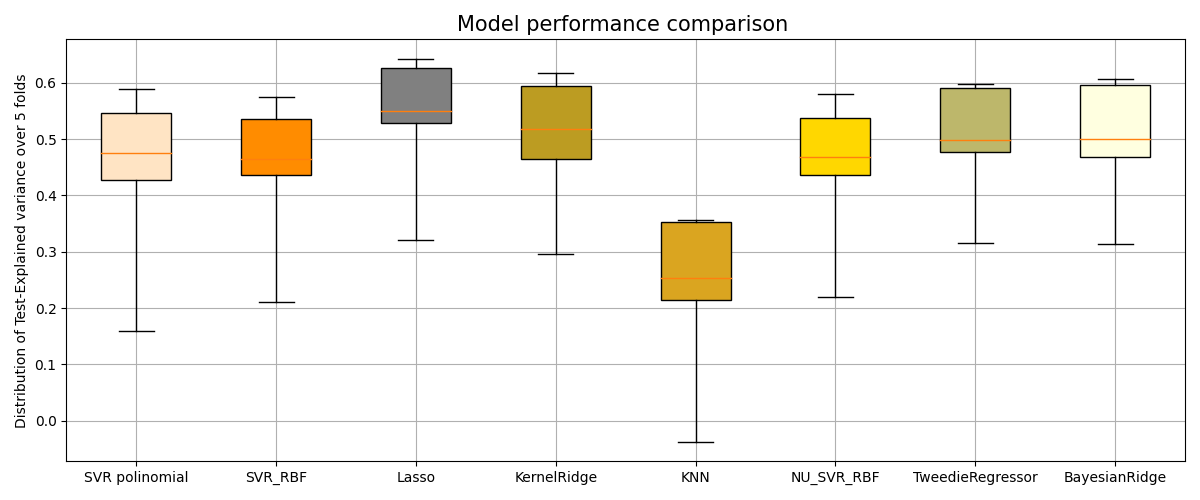

In [16]:
best_ex_variance_test_SVR_poly = np.load('/axon/scratch/dinja/notebooks/TUM/results/SVR_poly/best_ex_variance_test.npy')
best_ex_variance_test_SVR_RBF = np.load('/axon/scratch/dinja/notebooks/TUM/results/SVR_RBF/best_ex_variance_test.npy')
best_ex_variance_test_KernelRidge = np.load('/axon/scratch/dinja/notebooks/TUM/results/KernelRidge/best_ex_variance_test.npy')
best_ex_variance_test_Lasso = np.load('/axon/scratch/dinja/notebooks/TUM/results/Lasso/best_ex_variance_test.npy')
best_ex_variance_test_NU_SVR_RBF = np.load('/axon/scratch/dinja/notebooks/TUM/results/NU_SVR_RBF/best_ex_variance_test.npy')
best_ex_variance_test_KNN = np.load('/axon/scratch/dinja/notebooks/TUM/results/KNN/best_ex_variance_test.npy')
best_ex_variance_test_TweedieRegressor = np.load('/axon/scratch/dinja/notebooks/TUM/results/TweedieRegressor/best_ex_variance_test.npy')
best_ex_variance_test_BayesianRidge = np.load('/axon/scratch/dinja/notebooks/TUM/results/BayesianRidge/best_ex_variance_test.npy')

labels = ['SVR polinomial','SVR_RBF','Lasso','KernelRidge','KNN','NU_SVR_RBF','TweedieRegressor','BayesianRidge']

fig_model_perfo = plt.figure(figsize = (10,5),dpi = 100)
boxplot = plt.boxplot([best_ex_variance_test_SVR_poly,
                       best_ex_variance_test_SVR_RBF,
                       best_ex_variance_test_Lasso,
                       best_ex_variance_test_KernelRidge,
                       best_ex_variance_test_KNN,
                       best_ex_variance_test_NU_SVR_RBF,
                       best_ex_variance_test_TweedieRegressor,
                       best_ex_variance_test_BayesianRidge],labels = labels,whis = 20,patch_artist=True)

plt.title('Model performance comparison ',fontsize = 15)
plt.ylabel('Distribution of Test-Explained variance over 5 folds',fontsize = 10)

colors = ['bisque', 'darkorange','gray', '#bc9c22','goldenrod','gold','darkkhaki','lightyellow']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
plt.grid()

fig_model_perfo.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/Model_performance.pdf',bbox_inches ='tight', dpi = 400)
plt.show()

#-Dinuka Jayalath-

# **Step 6 :- Model Optimization**

## 6.1 Single Hyperparameter Influence for selected models

Mainly the LASSO model and SVR (rbf) were chosen for further optimization based on performance metrics. We discarded other models from further optimization due to their inferior performance metrics. These has been chosen beacuse there are only few hyper parameter for optimization and its less complex than the others.

The selected models will be evaluated for optimization process with MSE and Explained variance regression score.

**Splitting the data to use in optimization process**

In [12]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(Input_all, Output_all, test_size=0.2, random_state=42,shuffle = True)  # splitting data

### Training and Testing performance with LASSO for different C values

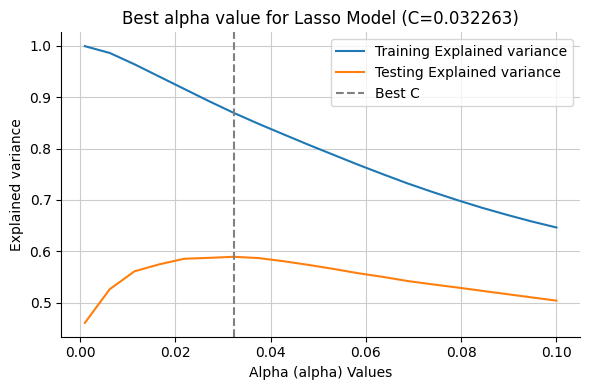

In [54]:
Cs = np.linspace(0.001, 0.1, num = 20)   

train_ex_variance = []
test_ex_variance = []

for C in Cs:
    
    #training the model 
    model = linear_model.Lasso(alpha=C,max_iter = -1)
    model.fit(X_train_all, y_train_all)
    
    # for training 
    y_preds_train = model.predict(X_train_all)
    ex_variance_train = explained_variance_score(y_train_all,y_preds_train)
    train_ex_variance.append(ex_variance_train)

    # for test data 
    y_preds_test = model.predict(X_test_all)
    ex_variance_test = explained_variance_score(y_test_all,y_preds_test)
    test_ex_variance.append(ex_variance_test)


best_C = Cs[np.argmax(test_ex_variance)]

fig_lasso_train_test = plt.figure(dpi = 100)
ax = fig_lasso_train_test.add_subplot(111)
ax.plot(Cs,train_ex_variance,label = "Training Explained variance")
ax.plot(Cs,test_ex_variance,label = "Testing Explained variance")

ax.set_xlabel("Alpha (alpha) Values")
ax.set_ylabel("Explained variance")
ax.grid(color="#CCCCCC")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(best_C,color="grey",linestyle="dashed",label="Best C")
plt.title("Best alpha value for Lasso Model (C=%f)" % best_C)
plt.legend()
plt.tight_layout()

fig_lasso_train_test.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/best_C_for_lasso_Model.pdf',bbox_inches ='tight', dpi = 300)

#-Dinuka Jayalath-

## 6.2 Investigating minimum number of Principal Components to achive best performance

Using too less PCs would not represent a higher cumulative explained variance ratio. Contrarily, even though too many PCs would not achieve the dimensionality reduction that we expect. Therefore, finding the minimum number of PCs to reach the maximum performance is important.

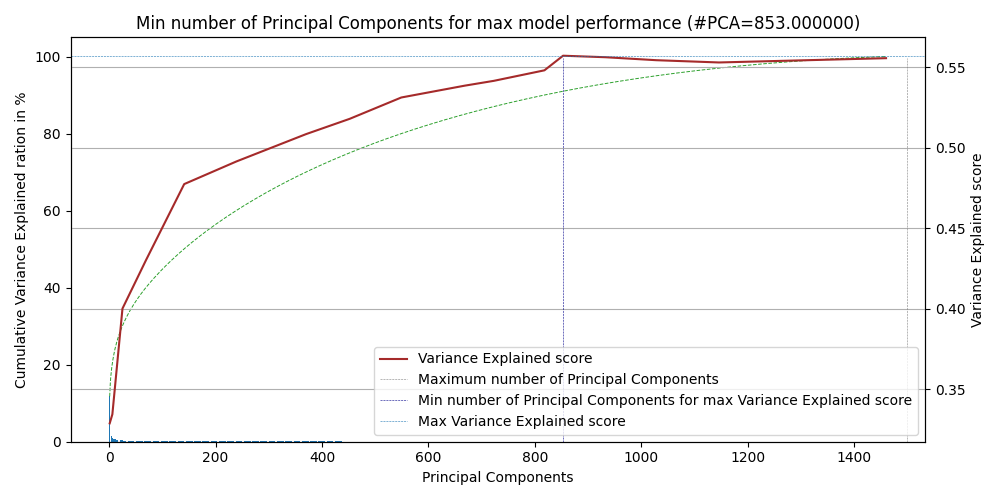

In [18]:
presentage_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.87,0.9,0.91,0.93,0.95,0.97,None] 

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train_all)
scaled_X_test = scaler.transform(X_test_all)

pca_ex_variance_list = []
n_values = []
for i in presentage_list:
    
    pca = PCA(i)
    X_train_all_pca = pca.fit_transform(scaled_X_train)
    X_test_all_pca = pca.transform(scaled_X_test)
    n = (X_train_all_pca.shape)[1]                          # the number of pcs selected
    
    model = linear_model.Lasso(alpha =  0.032 ,max_iter = -1)
    model.fit(X_train_all_pca,y_train_all )
    y_pred = model.predict(X_test_all_pca)
    ex_variance_pca = explained_variance_score(y_test_all,y_pred)
    pca_ex_variance_list.append(ex_variance_pca)
    n_values.append(n)
    
fig_best_pca = plt.figure(dpi=100,figsize=(10,5))
ax1 = fig_best_pca.add_subplot(111)

ax1.bar(np.arange(1,1+len(pca.explained_variance_[0:n])),pca.explained_variance_ratio_[0:n]*100)
ax1.plot(np.arange(1,1+len(pca.explained_variance_[0:n])), np.cumsum(pca.explained_variance_ratio_[0:n])*100,color="tab:green", label = 'Cumulative Variance Explained',linestyle = '--',linewidth = 0.7)

ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Cumulative Variance Explained ration in %')
ax2 = ax1.twinx()
ax2.plot(n_values,pca_ex_variance_list, c = 'brown',label = 'Variance Explained score',linewidth = 1.5)
ax2.set_ylabel('Variance Explained score')

plt.axvline(1500,ymax = 0.95,linewidth = 0.4,linestyle = '--',label = 'Maximum number of Principal Components', color = 'gray')
plt.axvline(n_values[np.argmax(pca_ex_variance_list)],ymax = 0.95,linewidth = 0.4,linestyle = '--',label = 'Min number of Principal Components for max Variance Explained score', color = 'darkblue')
plt.axhline(max(pca_ex_variance_list),xmax = 50,linewidth = 0.4,linestyle = '--',label = 'Max Variance Explained score')

plt.legend(fontsize = 10,loc = 'lower right')
plt.title('Min number of Principal Components for max model performance (#PCA=%f)'% n_values[np.argmax(pca_ex_variance_list)] )
plt.grid()
plt.tight_layout()
plt.show()

best_pca = n_values[np.argmax(pca_ex_variance_list)]

fig_best_pca.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/min_max_PCA_with_max_coefi.pdf',bbox_inches ='tight', dpi = 400)

# Dinuka --

**From this analysis we discovered that we have to use the maximum number of PCs resulting Explained variance score over 0.51.**

**Testing best PCs applied Input data**

In [31]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train_all)
scaled_X_test = scaler.transform(X_test_all)

pca = PCA(n_components = 853)# <--  number of PCs
X_train_pca = pca.fit_transform(scaled_X_train)
X_test_pca = pca.transform(scaled_X_test)

pca_model = linear_model.Lasso(alpha=0.032263 ,max_iter = -1)                                                           # Tested with the same C value as before 
pca_model.fit(X_train_pca,y_train_all)
pca_model_preds = pca_model.predict(X_test_pca)

pca_MSE_test = mean_squared_error(y_test_all,pca_model_preds)
pca_variance_score_test = explained_variance_score(y_test_all,pca_model_preds)

print("MSE (Test): %.3f" % (pca_MSE_test))
print("explained_variance_score(Test): %.3f" % (pca_variance_score_test))

#-Dinuka Jayalath-

MSE (Test): 4.604
explained_variance_score(Test): 0.549


**Previous performance when not using PCA**
 - MSE (Test): 4.33 (+- 0.29)
 - Best Explained variance (Test): 0.53 (+- 0.12)

 
**There is an improvement; however, the performance of the model will be compromised slightly with reduced dimensions when using the PCs.**

## 6.3 Testing Feature Selection methods

*Feature selection works by selecting the best features based on statistics. It can be seen as a preprocessing step to an estimator. Furthermore, using feature selection can improve classification accuracy on a noisy dataset.*

### 6.3.1 Univariate feature selection with f_regression for different K values

**Performance when applying the selection on the dataset which has 5000 features in total**

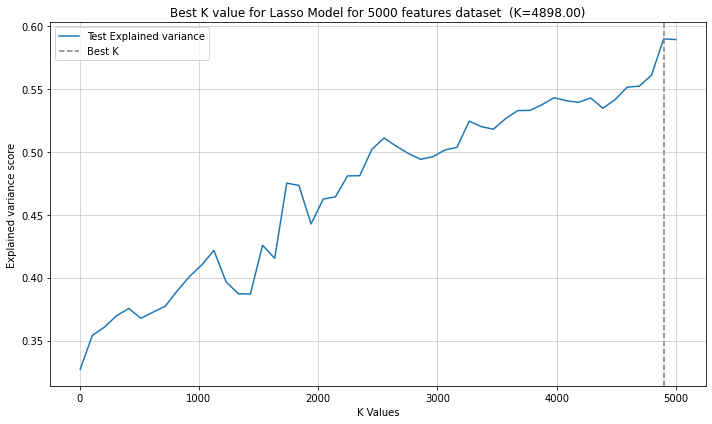

In [69]:
K_val_list = np.linspace(5,5000,50,dtype=int)

variance_score_clf_vals = []
for k_val in K_val_list:
    model_selecter = SelectKBest(f_regression,k = k_val)
    new_model = linear_model.Lasso(alpha = 0.0326 ,max_iter = -1)  
    
    selected_X_train = model_selecter.fit_transform(X_train_all,y_train_all)
    selected_X_test = model_selecter.transform(X_test_all)
    
    new_model.fit(selected_X_train,y_train_all)
    y_pred_clf = new_model.predict(selected_X_test)
    variance_score_clf = explained_variance_score(y_test_all,y_pred_clf)
    variance_score_clf_vals.append(variance_score_clf)
best_selected_k = K_val_list[np.argmax(variance_score_clf_vals)]

fig_SVR_rbf_UF = plt.figure(figsize=(10,6))
ax = fig_SVR_rbf_UF.add_subplot(111)
ax.plot(K_val_list,variance_score_clf_vals,label = "Test Explained variance")

ax.set_xlabel("K Values")
ax.set_ylabel("Explained variance score")
ax.grid(color="#CCCCCC")
plt.axvline(best_selected_k,color="grey",linestyle="dashed",label="Best K")
plt.title("Best K value for Lasso Model for 5000 features dataset  (K=%.2f)" % best_selected_k)
plt.legend()
plt.tight_layout()

fig_SVR_rbf_UF.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/fig_SVR_rbf_UF.pdf',bbox_inches ='tight', dpi = 300)

#-Dinuka Jayalath-

This plot shows that U-f_regression feature selection is not ideal to be used as a dimentionality reduction approach or feature selection approach since it compromises the model porformance drastically when reducing the features.

### 6.3.2  SelectFromModel feature selection

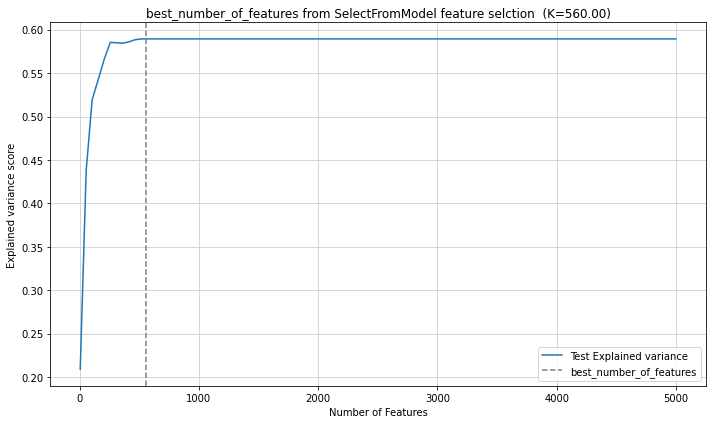

In [73]:
feature_number_list = np.linspace(5,5000,100,dtype=int)

variance_score_clf_vals = []
for feature_number in feature_number_list:
    estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1)                        # Lasso is used as the feature selecting estimator
    selector = SelectFromModel(estimator=estimator,max_features = feature_number)    # Number of features selected
    
    selected_X_train = selector.fit_transform(X_train_all,y_train_all)
    selected_X_test = selector.transform(X_test_all)
    
    new_model = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
    new_model.fit(selected_X_train,y_train_all)
    y_pred_clf = new_model.predict(selected_X_test)
    variance_score_clf = explained_variance_score(y_test_all,y_pred_clf)
    variance_score_clf_vals.append(variance_score_clf)
    
best_number_of_features = feature_number_list[np.argmax(variance_score_clf_vals)]

fig_Lasso_SelectFromModel = plt.figure(figsize=(10,6))
ax = fig_Lasso_SelectFromModel.add_subplot(111)
ax.plot(feature_number_list,variance_score_clf_vals,label = "Test Explained variance")

ax.set_xlabel("Number of Features")
ax.set_ylabel("Explained variance score")
ax.grid(color="#CCCCCC")
plt.axvline(best_number_of_features,color="grey",linestyle="dashed",label="best_number_of_features")
plt.title("best_number_of_features from SelectFromModel feature selction  (K=%.2f)" % best_number_of_features)
plt.legend()
plt.tight_layout()

fig_Lasso_SelectFromModel.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/fig_Lasso_SelectFromModel.pdf',bbox_inches ='tight', dpi = 300)

#-Dinuka Jayalath-

This plot shows that SelectFromModel feature selection could be used for dimentionality reduction up to **560** without compromising the model performance but increasing it over 0.55

**Testing the analysis of SelectFromModel selected minimum feature number with a new model**

In [29]:
estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

new_model = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
new_model.fit(X_train_all_selected,y_train_all)
new_model_preds = new_model.predict(X_test_all_selected)

new_model_MSE_test = mean_squared_error(y_test_all,new_model_preds)
new_model_variance_score_test = explained_variance_score(y_test_all,new_model_preds)

print('Shape of the selected Input_all Array:\t'+ str(X_train_all_selected.shape))
print("MSE (Test): %.3f" % (new_model_MSE_test))
print("explained_variance_score(Test): %.3f" % (new_model_variance_score_test))

#-Dinuka Jayalath-

Shape of the selected Input_all Array:	(1460, 559)
MSE (Test): 4.166
explained_variance_score(Test): 0.589


**Previous performance when not using dimentionality reduction at all**
 - MSE (Test): 4.634
 - explained_variance_score(Test): 0.547

**The results show that there is a significant improvement on the model performance when using SelectFromModel feature selection.**

**With this strategy we could reduce the total dimentions/features down to 560 without compromising the model performance but also increasing it**

## 6.4 Hyperparameter tuning 

**Range for alpha**

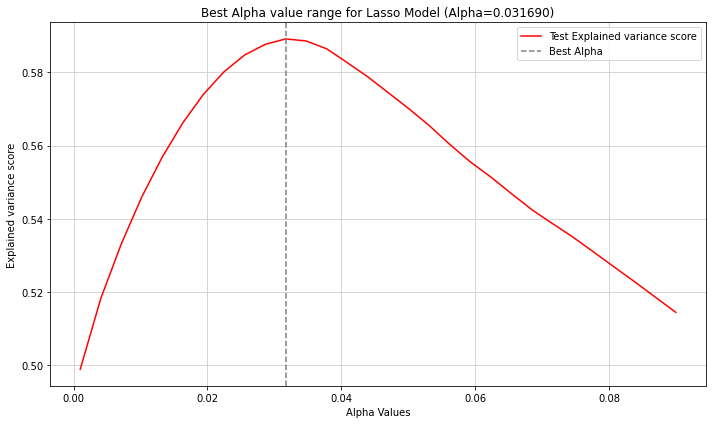

In [75]:
alpha_val_list = np.linspace(0.001,0.09,30)
variance_score_alpha_list = []
for a in alpha_val_list:
    
    estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1)           # Model selector alpha is a constant
    selector = SelectFromModel(estimator=estimator,max_features = 560)   # from the above test

    X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
    X_test_all_selected = selector.transform(X_test_all)

    new_model = linear_model.Lasso(alpha = a, max_iter = -1) 
    new_model.fit(X_train_all_selected,y_train_all)
    new_model_preds = new_model.predict(X_test_all_selected)
    
    new_model_variance_score_test = explained_variance_score(y_test_all,new_model_preds)
    variance_score_alpha_list.append(new_model_variance_score_test)
    
best_alpha = alpha_val_list[np.argmax(variance_score_alpha_list)]

fig_lasso_selector_alpha = plt.figure(figsize=(10,6))
ax = fig_lasso_selector_alpha.add_subplot(111)

ax.plot(alpha_val_list,variance_score_alpha_list,label = "Test Explained variance score",c = 'red')

ax.set_xlabel("Alpha Values")
ax.set_ylabel("Explained variance score")
ax.grid(color="#CCCCCC")
plt.axvline(best_alpha,color="grey",linestyle="dashed",label="Best Alpha")
plt.title("Best Alpha value range for Lasso Model (Alpha=%f)" % best_alpha)
plt.legend()
plt.tight_layout()

fig_lasso_selector_alpha.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/fig_lasso_selector_alpha.pdf',bbox_inches ='tight', dpi = 400)

#-Dinuka Jayalath-

### 6.4.1 RandomizedSearchCV for selected models

Since RandomizedSearchCV is not computationally expensive like GridsearchCV it can be used to get an idea about the range of parameters and the influence within a short time. Later we can apply the Grid search for selected Models or parameters if possible

**Lasso Model**

In [77]:
estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)   # from the above test

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

tuned_parameters = [{"alpha": np.linspace(0.01, 0.05, num = 20) ,"fit_intercept":[True,False], "normalize": [True,False],'positive':[True,False]}]
scores = 'explained_variance'

print("# Tuning hyper-parameters for %s" % scores)
GSRCV = RandomizedSearchCV(linear_model.Lasso(max_iter = -1), param_distributions = tuned_parameters,scoring = scores)
GSRCV.fit(X_train_all_selected, y_train_all)
print("Best parameters set found for the best score:")
print()
print(GSRCV.best_params_)
print()
print('Best score ',GSRCV.best_score_)

#-Dinuka Jayalath-

# Tuning hyper-parameters for explained_variance
Best parameters set found for the best score:

{'positive': False, 'normalize': False, 'fit_intercept': True, 'alpha': 0.020526315789473684}

Best score  0.7491133821456886


**SVR rbf Model as the final estimator**

*Since SVR(rbf) also performed well we tested it as the final estimator this model was less complex and had less parameters to optimised*

In [139]:
estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)   # from the above test

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

tuned_parameters = [{"kernel": ["rbf"], "gamma": np.linspace(0.0001,0.0008,10),"epsilon":np.linspace(0,1,10), "C": np.linspace(10,40,10)}]
scores = 'explained_variance'

print("# Tuning hyper-parameters for %s" % scores)
GSRCV = RandomizedSearchCV(svm.SVR(max_iter = -1), param_distributions = tuned_parameters,scoring = scores)
GSRCV.fit(X_train_all_selected, y_train_all)
print("Best parameters set found for the best score:")
print()
print(GSRCV.best_params_)
print()
print('Best score ',GSRCV.best_score_)

#-Dinuka Jayalath-

# Tuning hyper-parameters for explained_variance
Best parameters set found for the best score:

{'kernel': 'rbf', 'gamma': 0.0003333333333333333, 'epsilon': 0.3333333333333333, 'C': 23.333333333333336}

Best score  0.836301816889929


**This results seem over optimistic because for the cross validation in RandomizedSearchCV uses the given X_train and y_train for split.**

### 6.4.2 Grid Search CV 

**Lasso**

In [79]:
estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)   # from the above test

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

tuned_parameters = [{"alpha": np.linspace(0.02, 0.04, num = 20),"fit_intercept":[True,False], "normalize": [True,False],'positive':[True,False]}]
scores = 'explained_variance'

print("# Tuning hyper-parameters for %s" % scores)
GSCV = GridSearchCV(linear_model.Lasso(max_iter = -1), param_grid = tuned_parameters,scoring = scores)
GSCV.fit(X_train_all_selected, y_train_all)

print("Best parameters set found for the best score:")
print()
print(GSCV.best_params_)
print()
print('Best score ',GSCV.best_score_)

#-Dinuka Jayalath-

# Tuning hyper-parameters for explained_variance
Best parameters set found for the best score:

{'alpha': 0.02, 'fit_intercept': True, 'normalize': False, 'positive': False}

Best score  0.7520855024159874


**SVR rbf Model as the final estimator**

In [140]:
estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)   # from the above test

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

tuned_parameters = [{"kernel": ["rbf"], "gamma": np.linspace(0.0001,0.0008,7),"epsilon":np.linspace(0,1,7), "C": np.linspace(10,40,7)}]
scores = 'explained_variance'

print("# Tuning hyper-parameters for %s" % scores)
GSRCV = GridSearchCV(svm.SVR(max_iter = -1), param_grid = tuned_parameters,scoring = scores)
GSRCV.fit(X_train_all_selected, y_train_all)
print("Best parameters set found for the best score:")
print()
print(GSRCV.best_params_)
print()
print('Best score ',GSRCV.best_score_)

#-Dinuka Jayalath-

# Tuning hyper-parameters for explained_variance
Best parameters set found for the best score:

{'C': 25.0, 'epsilon': 0.16666666666666666, 'gamma': 0.00021666666666666666, 'kernel': 'rbf'}

Best score  0.8373628698704298


**Test Lasso as the feature selection and SVR rbf as the final estimator**

In [30]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(Input_all, Output_all, test_size=0.2, random_state=42,shuffle = True)  # splitting data
estimator = linear_model.Lasso(alpha=0.0326,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

new_model = svm.SVR(max_iter = -1, gamma = 0.00021666    ,epsilon = 0.16666 , C = 25) 
new_model.fit(X_train_all_selected,y_train_all)
new_model_preds = new_model.predict(X_test_all_selected)

new_model_MSE_test = mean_squared_error(y_test_all,new_model_preds)
new_model_variance_score_test = explained_variance_score(y_test_all,new_model_preds)

print('Shape of the selected Input_all Array:\t'+ str(X_train_all_selected.shape))
print("MSE (Test): %.3f" % (new_model_MSE_test))
print("explained_variance_score(Test): %.3f" % (new_model_variance_score_test))

#-Dinuka Jayalath-

Shape of the selected Input_all Array:	(1460, 559)
MSE (Test): 4.637
explained_variance_score(Test): 0.544


**Previous performance with both estimators as Lasso**

 - MSE (Test): 4.166
 - explained_variance_score(Test): 0.589
 
**The results show that using SVR rbf as the final estimator is not ideal**

### 6.4.3 Testing the influence of base estimator's alpha value on model performance

In [13]:
estimator_alpha_val_list = np.linspace(0.01, 0.1, num =15)
final_model_alpha_val_list = np.linspace(0.001, 0.07, num = 10)


explained_variance_score_list = []
estimator_alpha = []
final_model_alpha = []

for estimator_alpha_val in estimator_alpha_val_list:
    
    estimator = linear_model.Lasso(alpha = estimator_alpha_val,max_iter = -1) 
    selector = SelectFromModel(estimator=estimator,max_features = 560)
    X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
    X_test_all_selected = selector.transform(X_test_all)
    
    for final_model_alpha_val in final_model_alpha_val_list:
        
        new_model = linear_model.Lasso(alpha = final_model_alpha_val,max_iter = -1) # Other grid search parameters are default parameters so no need to specify
        new_model.fit(X_train_all_selected,y_train_all)
        new_model_preds = new_model.predict(X_test_all_selected)
        new_model_variance_score_test = explained_variance_score(y_test_all,new_model_preds)
        
        explained_variance_score_list.append(new_model_variance_score_test)
        estimator_alpha.append(round(estimator_alpha_val, 3))
        final_model_alpha.append(round(final_model_alpha_val, 3))
        
resutlts_dataframe = pd.DataFrame({'estimator_alpha':estimator_alpha,'final_model_alpha':final_model_alpha,'explained_variance_score': explained_variance_score_list})

#-Dinuka Jayalath-

In [14]:
df1 = resutlts_dataframe.set_index(['estimator_alpha','final_model_alpha'])['explained_variance_score']
df2 = df1.unstack(1)
df2.style.highlight_max(color = 'lightgreen', axis = None)

#-Dinuka Jayalath-

final_model_alpha,0.001,0.009,0.016,0.024,0.032,0.039,0.047,0.055,0.062,0.07
estimator_alpha,,,,,,,,,,
0.01,0.473640,0.524002,0.551339,0.561753,0.566982,0.567940,0.565645,0.558109,0.548433,0.537863
0.016,0.485230,0.531988,0.562732,0.575997,0.581852,0.580329,0.572357,0.562794,0.552269,0.540800
0.023,0.507326,0.546686,0.575611,0.588479,0.591432,0.587407,0.577111,0.564822,0.552225,0.540554
0.029,0.505568,0.542416,0.568838,0.584019,0.589088,0.584430,0.574468,0.563215,0.551420,0.539903
0.036,0.518958,0.550009,0.571319,0.584514,0.589208,0.584818,0.574557,0.562956,0.551449,0.540534
0.042,0.534683,0.561789,0.577077,0.585900,0.588353,0.584356,0.574827,0.563656,0.552290,0.540770
0.049,0.547781,0.566970,0.577441,0.583405,0.585024,0.582197,0.574797,0.563418,0.552069,0.540474
0.055,0.541096,0.559072,0.570453,0.577505,0.580250,0.578767,0.573221,0.563267,0.551930,0.540212
0.061,0.520770,0.540035,0.552307,0.561093,0.566421,0.568247,0.566547,0.561146,0.552013,0.540416


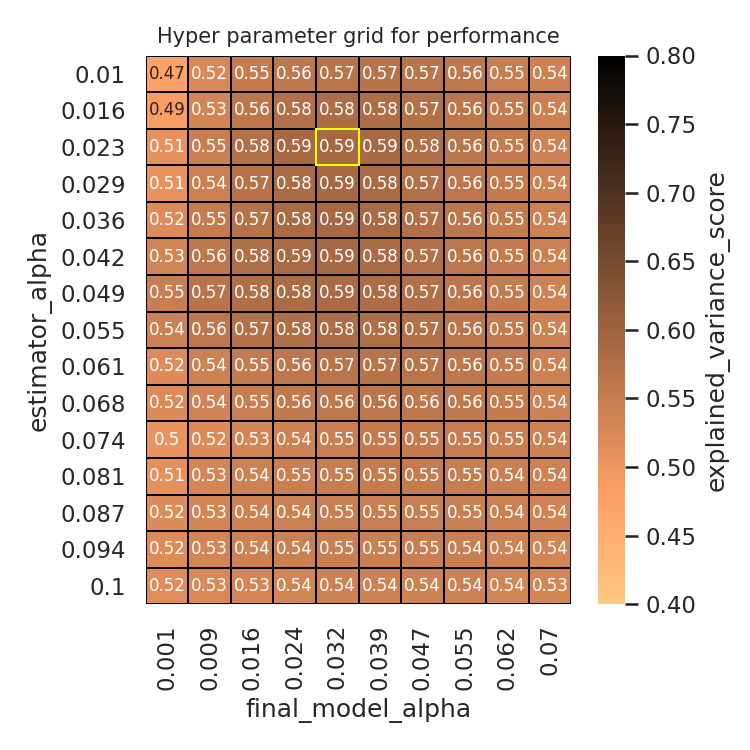

In [46]:
fig_heatmap_alpha = plt.figure(figsize=(5,5),dpi  =150)
ax = fig_heatmap_alpha.add_subplot(111)
ax = sns.heatmap(df2,vmin=0.4, vmax=0.8,annot=True,annot_kws={"size":8},cbar_kws = {'label':'explained_variance_score'},cmap = 'copper_r',linecolor = 'black',linewidths = 0.01)
sns.set(rc = {'figure.figsize':(5,5)})
ax.add_patch(Rectangle((4,2),1,1, fill=False, edgecolor='yellow', lw=1))
plt.title('Hyper parameter grid for performance',fontsize = 10)
plt.show()

#fig_heatmap_alpha.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/fig_heatmap_alpha.pdf',bbox_inches ='tight', dpi = 400)

#-Dinuka Jayalath-

**Testing with new parameters**

In [25]:
estimator = linear_model.Lasso(alpha=0.023,max_iter = -1) 
selector = SelectFromModel(estimator=estimator,max_features = 560)

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

new_model = linear_model.Lasso(alpha=0.032,max_iter = -1) # Other grid search parameters are default parameters 
new_model.fit(X_train_all_selected,y_train_all)           # so no need to specify
new_model_preds = new_model.predict(X_test_all_selected)

new_model_MSE_test = mean_squared_error(y_test_all,new_model_preds)
new_model_variance_score_test = explained_variance_score(y_test_all,new_model_preds)

print('Shape of the selected Input_all Array:\t'+ str(X_train_all_selected.shape))
print("MSE (Test): %.3f" % (new_model_MSE_test))
print("explained_variance_score(Test): %.3f" % (new_model_variance_score_test))
print("10 fold CV score ('explained_variance'): %.3f (+- %.3f)" % (new_model_CV_SCORE.mean(), new_model_CV_SCORE.std()))

#-Dinuka Jayalath-

Shape of the selected Input_all Array:	(1460, 560)
MSE (Test): 4.143
explained_variance_score(Test): 0.592
10 fold CV score ('explained_variance'): 0.332 (+- 0.208)


**Previous performance scores were**
- MSE (Test): 4.306
- explained_variance_score(Test): 0.575
- 10 fold CV score ('explained_variance'): 0.659 (+- 0.103)

**The results show that it was important to adjust the base estimator alpha well for the performance**

## 6.5 The final Model

**Model prediction Vs True phenotypic values**

MSE (Test): 4.143
explained_variance_score(Test): 0.592
10 fold CV score ('explained_variance'): 0.332 (+- 0.208)


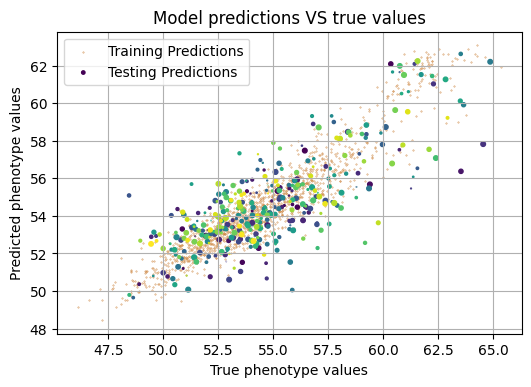

In [14]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(Input_all, Output_all, test_size=0.2, random_state=42,shuffle = True) 
estimator = linear_model.Lasso(alpha = 0.023 ,max_iter = -1)          # optimized alpha value
selector = SelectFromModel(estimator=estimator,max_features = 560)  # optimized max features value

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

Final_model = linear_model.Lasso(alpha=0.032,max_iter = -1)  # final estimator with best parameters

Final_model.fit(X_train_all_selected,y_train_all)

Final_model_preds_train = Final_model.predict(X_train_all_selected)  #training predictions
Final_model_preds_test = Final_model.predict(X_test_all_selected)    #Testing predictions

Final_model_MSE_test = mean_squared_error(y_test_all,Final_model_preds_test)
Final_model_variance_score_test = explained_variance_score(y_test_all,Final_model_preds_test)

Final_model_CV_SCORE = cross_val_score(Final_model,X_test_all_selected,y_test_all, cv=10,scoring = 'explained_variance')    # CV is done with the new Input_all but transformed

print("MSE (Test): %.3f" % (Final_model_MSE_test))
print("explained_variance_score(Test): %.3f" % (Final_model_variance_score_test))
print("10 fold CV score ('explained_variance'): %.3f (+- %.3f)" % (Final_model_CV_SCORE.mean(), Final_model_CV_SCORE.std()))

colors = np.arange(366)
area = (3 * np.random.rand(366)*4)
fig_best_coefi = plt.figure(dpi = 100)
plt.grid()
plt.scatter(y_train_all, Final_model_preds_train,s=0.1,c= 'peru',label = 'Training Predictions')
plt.scatter(y_test_all, Final_model_preds_test, s = area,c= colors,label = 'Testing Predictions')

plt.title("Model predictions VS true values")
plt.xlabel("True phenotype values")
plt.ylabel('Predicted phenotype values')
plt.legend()
plt.show()

fig_best_coefi.savefig('/axon/scratch/dinja/notebooks/TUM/Project/figures/fig_best_coefi.pdf',bbox_inches ='tight', dpi = 400)

#-Dinuka Jayalath-

**Since the Lasso model performs best with tuned hyperparameters that has been choosen as the final model**

 - The optimization process has been able to increase the Explained variance from 0.53 up to 0.592. 
 
**what we can do next ?**

- If the computation power and time is not a constrain we could do a grid search CV for hyper parameters but this is very computationally expensive.
- Testing complex neural network models like SGDRegressor, RandomForestRegressor.
- It seems like there is lower number of samples for the higher bio mass, therefore the model is not learning very well or genaralize for those higher biomasses.

# Step 7 :- Preparing leader board predictions

## 7.1 Importing data and preprocessing

In [45]:
unknown_genotypes_df = pd.read_csv('unknown_genotypes.csv') 
unknown_genotypes_df = unknown_genotypes_df.sort_values(by=["sample_ids"], ascending=True)

sample_IDs_unknown = unknown_genotypes_df['sample_ids'].to_numpy() # this is to make the dataframe in the end

Input_all_unknown_replaced_df = question_mark_replacement(unknown_genotypes_df)  # imputing the ? with the pre defined function
Input_all_unknown = aditive_encoding(Input_all_unknown_replaced_df)              # encoding with the pre defined function

print('Shape of the Input_all Array -->', Input_all_unknown.shape)

## -Lakruvini- -Dinuka Jayalath-

Shape of the Input_all Array --> (203, 5000)


## 7.2 Training the model with best parameters with Input data and Output data

In [48]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(Input_all, Output_all, test_size=0.2, random_state=42,shuffle = True) 

estimator = linear_model.Lasso(alpha = 0.023 ,max_iter = -1)          # optimized alpha value
selector = SelectFromModel(estimator=estimator,max_features = 560)  # optimized max features value

X_train_all_selected = selector.fit_transform(X_train_all,y_train_all)
X_test_all_selected = selector.transform(X_test_all)

leader_model = linear_model.Lasso(alpha=0.032,max_iter = -1)  # final estimator with best parameters

leader_model.fit(X_train_all_selected,y_train_all)

Final_model_preds_train = leader_model.predict(X_train_all_selected)  #training predictions
Final_model_preds_test = leader_model.predict(X_test_all_selected)    #Testing predictions

Final_model_MSE_test = mean_squared_error(y_test_all,Final_model_preds_test)
Final_model_variance_score_test = explained_variance_score(y_test_all,Final_model_preds_test)


print("MSE (Test): %.3f" % (Final_model_MSE_test))
print("explained_variance_score(Test): %.3f" % (Final_model_variance_score_test))

MSE (Test): 4.143
explained_variance_score(Test): 0.592


In [53]:
# Get the predictions from the final model 
# model

leader_model = linear_model.Lasso(alpha=0.032,max_iter = -1)  # final estimator with best parameters

#Transforming unknown data

estimator = linear_model.Lasso(alpha = 0.023 ,max_iter = -1)          # optimized alpha value
selector = SelectFromModel(estimator = estimator,max_features = 560)  # optimized max features value

Input_all_selected = selector.fit_transform(Input_all,Output_all)     # Using the whole dataset
unknown_transformed = selector.transform(Input_all_unknown)           # unkown data transfomation

leader_model.fit(Input_all_selected,Output_all)                       # Using the whole dataset to fit the model

#Getting the unknown predictions

unknown_predictions = leader_model.predict(unknown_transformed)       # Getting the predictions

## 7.3 Getting the predictions to a CSV file from Input_all_unknown with the trained model

In [54]:

leader_model_predictions_df = pd.DataFrame(unknown_predictions,sample_IDs_unknown)

leader_model_predictions_df.to_csv('/axon/scratch/dinja/notebooks/TUM/results/leaderboard_10.csv', header=False)

# -Lakruvini- -Dinuka Jayalath-

In [55]:
leader_model_predictions_df

,0
7,54.232713
8,56.646245
60,52.832090
104,54.929002
126,52.922547
...,...
9985,52.887350
9991,53.393824
10011,53.774526
10022,56.085825


# References 

* scikit-learn documentation (https://scikit-learn.org/stable/index.html)
* Matplotlib 3.5.2 documentation (https://matplotlib.org/stable/index.html)
*  Influence of Feature Encoding and Choice of Classifier on Disease Risk Prediction in Genome-Wide Association Studies
 - Mittag F, Römer M, Zell A (2015) Influence of Feature Encoding and Choice of Classifier on Disease Risk Prediction in Genome-Wide Association Studies. PLOS ONE 10(8): e0135832. https://doi.org/10.1371/journal.pone.0135832
* SMOGN: a Pre-processing Approach for Imbalanced Regression
 - Branco, P., Torgo, L. and Ribeiro, R.P., 2017, October. SMOGN: a pre-processing approach for imbalanced regression. In First international workshop on learning with imbalanced domains: Theory and applications (pp. 36-50). PMLR.(http://proceedings.mlr.press/v74/branco17a/branco17a.pdf)